<a href="https://colab.research.google.com/github/LucaCappelletti94/covidxpert/blob/master/image_processing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline for image processing
The main goal of this Jupyter notebook is to prototype a working pipeline to preprocess chestxrays images.

In [35]:
! git clone https://github.com/LucaCappelletti94/covidxpert

fatal: destination path 'covidxpert' already exists and is not an empty directory.


In [90]:
import os
from glob import glob
import numpy as np, amax
from typing import List
import matplotlib.pyplot as plt

In [91]:
images = glob("covidxpert/sample_dataset/*")

In [92]:
real_bad_path = "covidxpert/sample_dataset/0ffcc21e-3dcb-4ca7-950b-856388a34d65.jpg"
bad_path = "covidxpert/sample_dataset/0b3b1768-5926-4084-bed0-ad9ae886d13a.jpg"
medium_path = "covidxpert/sample_dataset/0abbde89-55e8-4b25-ba9b-17a99f84bae0.jpg"
good_path = "covidxpert/sample_dataset/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg"

In [93]:
import cv2

def load_image(path:str)->np.ndarray:
  """Return normalized image at given path."""
  image = cv2.imread(path,0)
  image = (image - image.min()) / (image.max() - image.min())
  return np.pad(image, 10)

In [94]:
def get_convex_mask_threshold(image:np.ndarray)->float:
  """Return the threshold curresponding to the histogram peak."""
  counts, values = np.histogram(image, bins=100)
  return values[np.argmax(counts)]

In [95]:
def can_crop(image:np.ndarray, threshold:int=50)->bool:
  """Return a boolean representing if the histogram peak is relatively low."""
  return get_convex_mask_threshold(image) < threshold

In [96]:
from skimage.morphology import convex_hull_image

def convex_mask(image:np.ndarray)->np.ndarray:
  """Return image convex mask."""
  return convex_hull_image(image > 0)

In [97]:
from skimage.feature import corner_harris, corner_peaks, corner_subpix

def get_corners(image:np.ndarray, chull:np.ndarray)->List:
  """Return image corners."""
  return corner_peaks(corner_harris(chull), min_distance=1)

In [98]:
def get_bounding_box_extremes(chull:np.ndarray):
  indexes = np.where(chull > 0)
  min_x, min_y = np.min(indexes, axis=1)
  max_x, max_y = np.max(indexes, axis=1)
  return min_x, min_y, max_x, max_y

In [99]:
def cut_bounding_box(image:np.ndarray, chull:np.ndarray)->np.ndarray:
  """Cut the image using the given bounding box."""
  min_x, min_y, max_x, max_y = get_bounding_box_extremes(chull)
  return image[min_x:max_x, min_y:max_y]

In [100]:
def transpose_corners(corners:np.ndarray, chull:np.ndarray)->np.ndarray:
  min_x, min_y, _, _ = get_bounding_box_extremes(chull)
  return corners - (min_x, min_y)

In [101]:
def sort_corners(corners:np.ndarray)->np.ndarray:
  corners_list = corners.tolist()

  top_left_index = np.argmin(np.sum(corners, axis=1))
  top_left = corners_list[top_left_index]

  bottom_right_index = np.argmax(np.sum(corners, axis=1))
  bottom_right = corners_list[bottom_right_index]

  corners_list.remove(bottom_right)
  corners_list.remove(top_left)

  corners = np.array(corners_list)

  bottom_left = corners_list.pop(np.argmin(corners[:, 0]))

  # Getting the botton right corner
  top_right = corners_list.pop()

  return top_left, bottom_left, bottom_right, top_right

In [102]:
def perspective_correction(image:np.ndarray):
  chull = convex_mask(image)
  corners = get_corners(image, chull)
  image = cut_bounding_box(image, chull)
  corners = transpose_corners(corners, chull)
  corners = np.float32(sort_corners(corners))
  new_corners = np.float32([
    [0.0, 0.0], # top_left,
    [0.0, image.shape[1]], #top_right
    [image.shape[0], image.shape[1]], #bottom_right,
    [image.shape[0], 0], # bottom_left,
  ])
  new_corners = np.float32([
    (x, y) for y, x in new_corners.tolist()
  ])
  corners = np.float32([
    (x, y) for y, x in corners.tolist()
  ])
  M, _ = cv2.findHomography(
      corners,
      new_corners
  )
  return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

In [162]:
def affinity_cluster(vals:np.ndarray):
    # affinity propagation clustering
    from numpy import unique
    from numpy import where
    from sklearn.datasets import make_classification
    from sklearn.cluster import AffinityPropagation
    from matplotlib import pyplot
    # define dataset
    X = vals
    # define the model
#    if amax(myaffinity)==0:       
#    model = AffinityPropagation(damping=0.6)
#    else:
#    X = myaffinity
    
    model = AffinityPropagation(damping=0.6)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        # show the plot
        pyplot.show()
    return yhat

In [109]:
import cv2

real_bad = load_image(real_bad_path)
bad = load_image(bad_path)
medium = load_image(medium_path)
good = load_image(good_path)

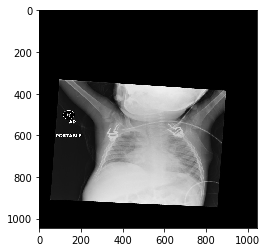

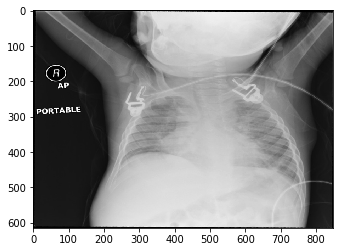

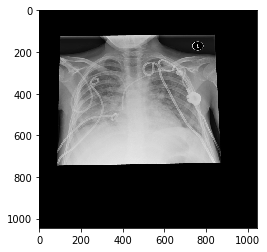

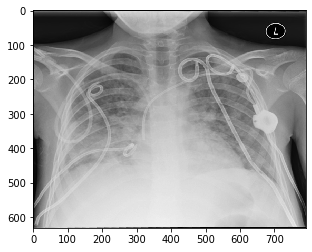

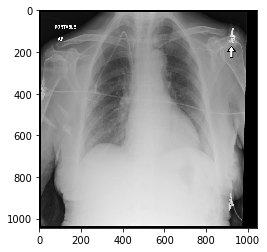

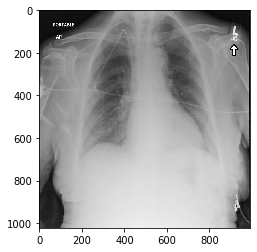

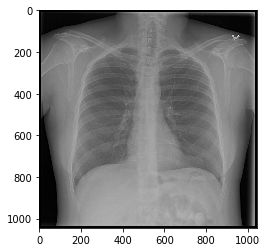

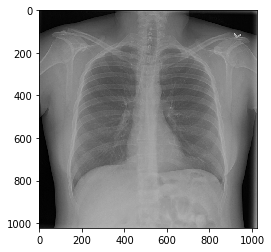

In [110]:
for image in (real_bad, bad, medium, good):
    plt.imshow(image, cmap="gray")
    plt.show()
    plt.imshow(perspective_correction(image), cmap="gray")
    plt.show()
    

In [111]:
wreal_bad = perspective_correction(real_bad)
wbad = perspective_correction(bad)
wmedium = perspective_correction(medium)
wgood = perspective_correction(good)


myaffinity [[0.         0.00402844 0.60753044]
 [0.00402844 0.         0.60677107]
 [0.60753044 0.60677107 0.        ]]


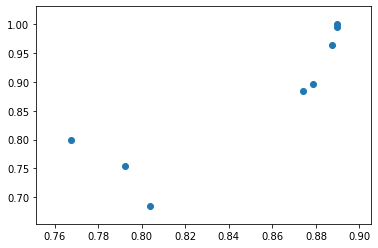

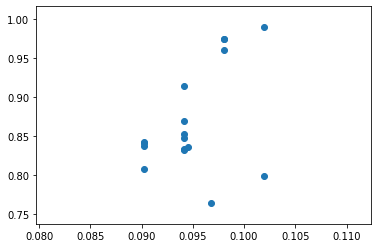

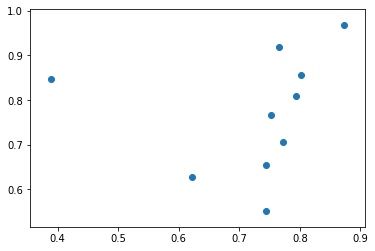

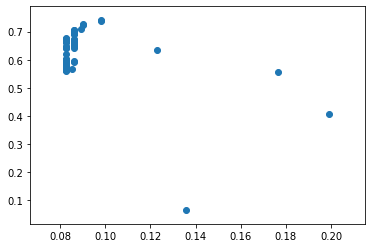

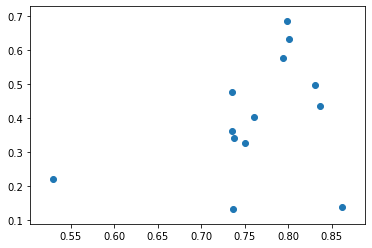

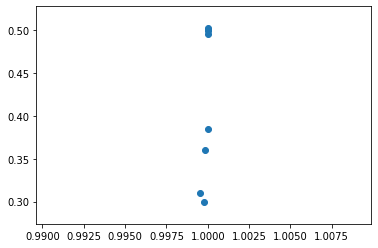

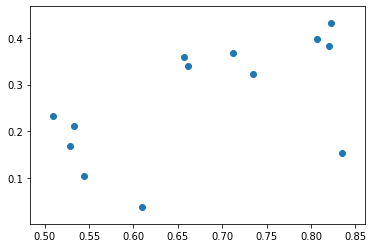

[0 0 1 1 1 2 0 1 2 1 0 0 1 2 1 1 2 1 1 1 1 1 1 2 1 0 1 2 1 0 3 3 3 3 3 2 3
 3 3 3 3 3 3 3 3 4 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 4 2 3 3
 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 5 5 5 5 4 5 4 4 6 3 4
 6 5 6 6 4 5 6 4 6 4 6 5 5 6 4 6 6 6 4 4 6 3 6]


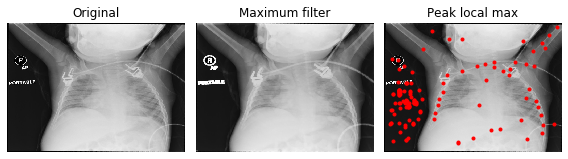

myaffinity [[0.         0.05817734 0.05896663]
 [0.05817734 0.         0.00091268]
 [0.05896663 0.00091268 0.        ]]


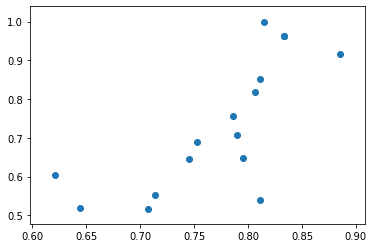

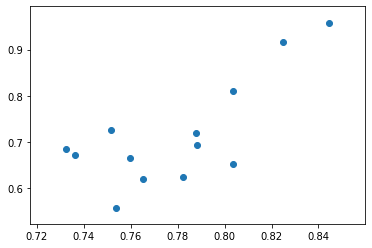

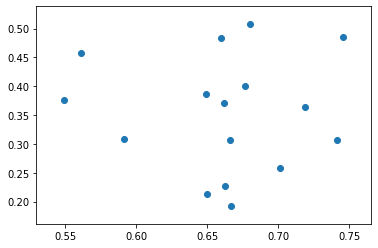

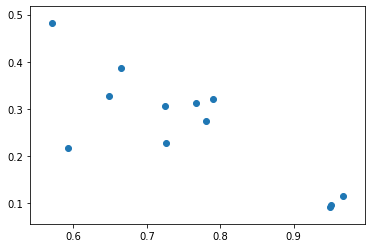

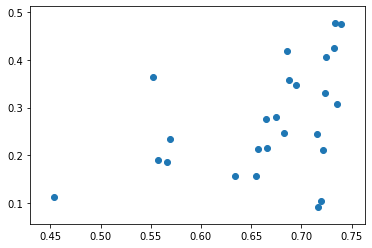

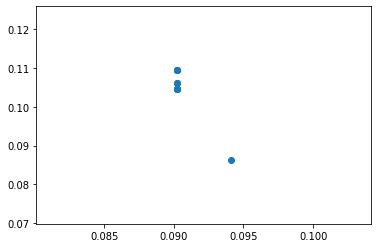

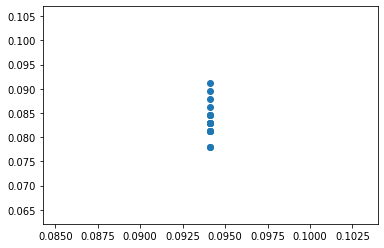

[0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 2 2 2 3 4 4 2 4
 4 4 2 3 2 2 2 4 2 4 4 4 3 3 3 4 2 3 2 2 4 4 3 2 4 4 4 3 2 3 4 4 2 4 2 4 4
 4 4 3 4 5 5 5 5 5 4 5 5 5 5 3 3 6 4 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


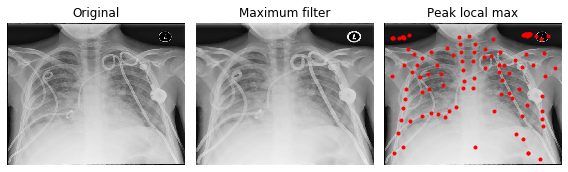

myaffinity [[0.         0.01672953 0.67173651]
 [0.01672953 0.         0.66671545]
 [0.67173651 0.66671545 0.        ]]


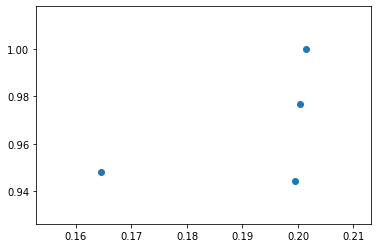

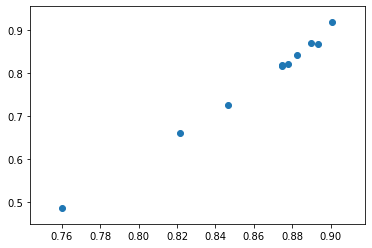

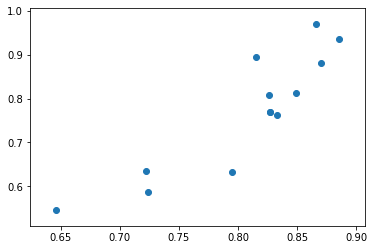

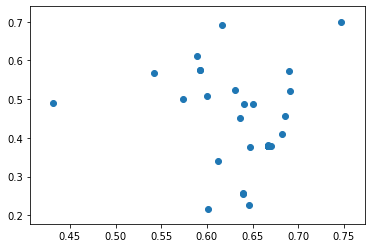

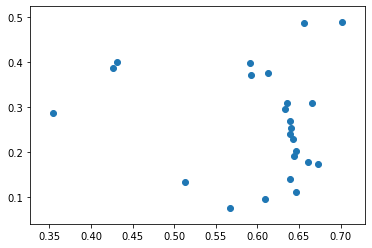

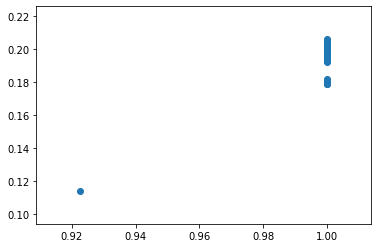

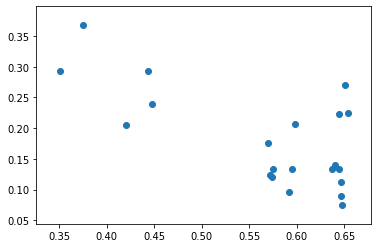

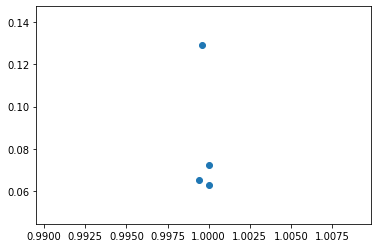

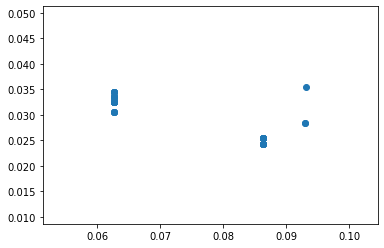

[0 0 2 0 0 2 1 2 2 1 1 1 1 1 1 2 2 2 2 2 1 3 3 1 2 2 3 2 3 3 3 3 2 3 3 3 3
 3 4 1 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 6 3 4 4 4 6 6 4 6 4
 3 3 4 4 6 4 3 6 6 3 6 5 5 6 5 5 5 5 4 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 4 6 4
 4 6 6 6 6 4 6 7 6 6 5 6 4 6 4 6 4 6 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


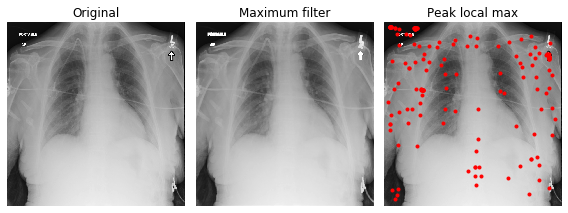

myaffinity [[0.         0.0051354  0.25062235]
 [0.0051354  0.         0.24621152]
 [0.25062235 0.24621152 0.        ]]


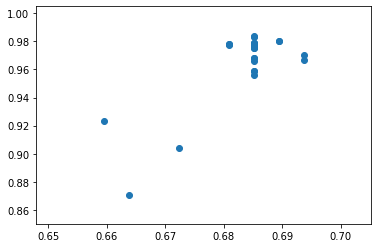

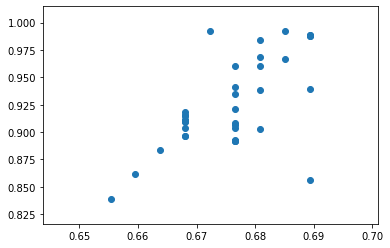

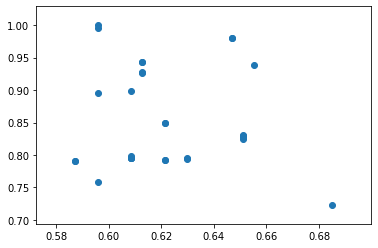

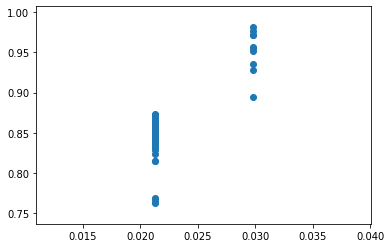

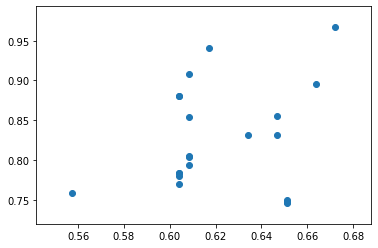

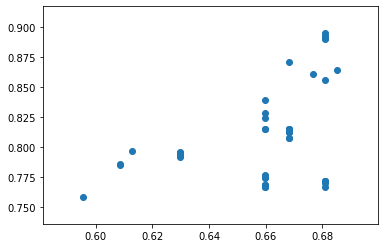

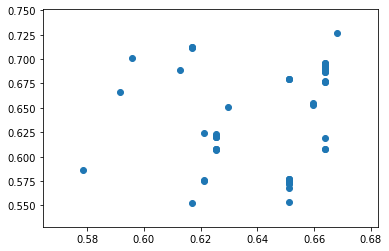

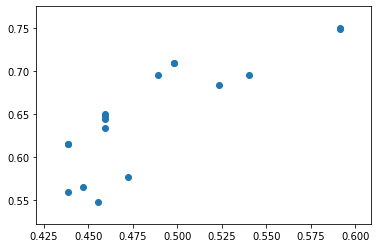

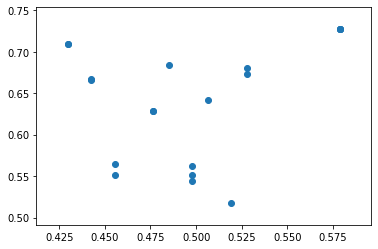

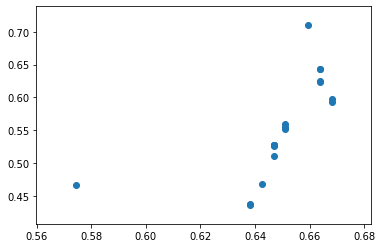

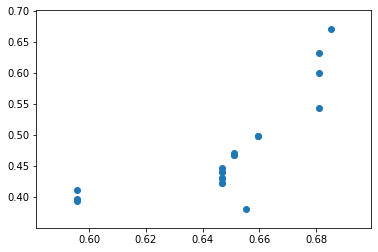

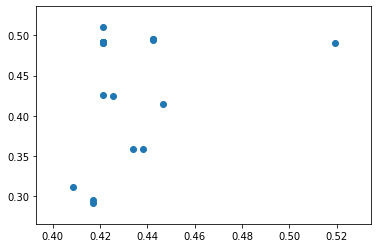

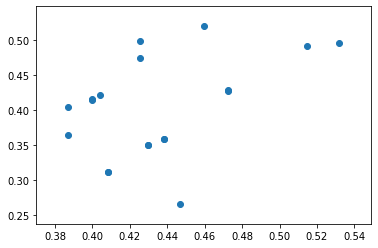

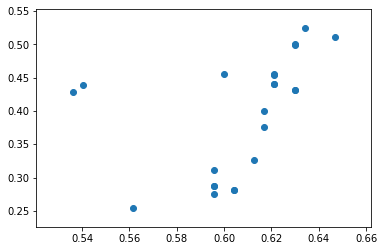

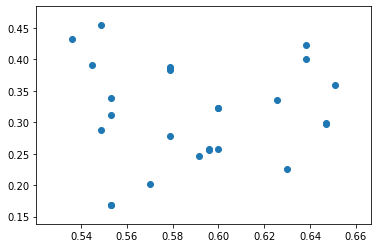

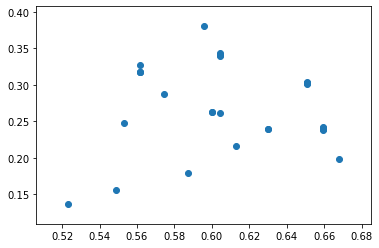

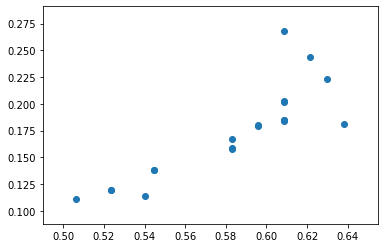

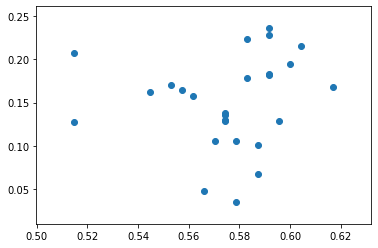

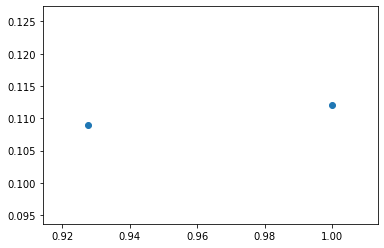

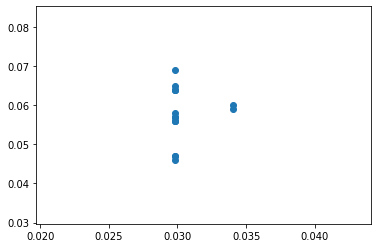

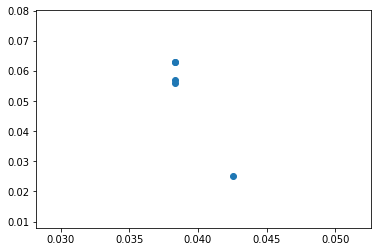

[ 2  2  1  1  1  1  1  1  0  1  0  2  3  2  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  3  3  0  1  0  0  0  1  4  0  1  1  0  0  0  3  3
  3  2  2  1  4  1  2  1  1  3  2  3  2  0  1  1  1  1  1  1  1  1  1  1
  4  1  0  1  1  1  2  1  1  2  5  4  3  1  5  1  1  1  5  5  5  1  4  4
  3  3  3  3  0  5  3  3  3  3  3  3  3  5  3  3  1  3  3  5  3  3  3  3
  5  1  3  4  4  3  3  2  2  3  3  3  3  3  3  3  3  3  3  5  1  3  3  3
  3  3  3  4  4  3  3  3  2  2  2  5  3  2  5  3  5  5  5  5  5  3  3  5
  5  5  5  5  4  4  2  5  2  2  2  5  2  2  5  5  2  5  4  5  2  2  5  2
  2  5  5  4  4  4  5  5  5  5  5  5  5  5  4  3  5  5  5  5  3  5  5  5
  3  3  2  4  5  7  4  7  4  4  8  8  8  8  6  2  6  6  6  7  9  7  8  8
  6  7  6  6  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  8  6  6  6  8  6  6  6  8 10  8  6  8  6  6  6  7  7  7
  9  9  8  7 10  8  8  9  6  9  6  6  6  6  6  6  6  7  7  6  6  6  6  6
  6 10  9  9  6  7  6  6  6  6  6  6  6  6  6  6  7

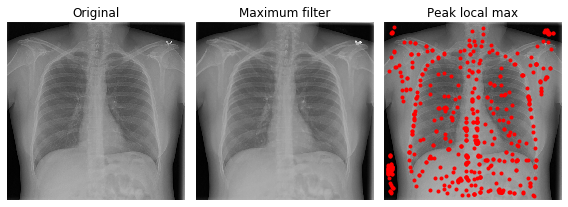

In [164]:

from skimage.exposure import histogram
from numpy import amax, add
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import img_as_float
from scipy.spatial import distance_matrix, distance

for image in (wreal_bad, wbad, wmedium, wgood):
    im = img_as_float(image)

    # image_max is the dilation of im with a 20*20 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=5, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    coordinates = peak_local_max(im, min_distance=20)
    
    points = image[coordinates[:,0], coordinates[:,1]]
    
    pointsS = np.column_stack((points,
                              np.true_divide(coordinates[:,0],max(coordinates[:,0])), 
                              np.true_divide(coordinates[:,1],max(coordinates[:,1]))))
 
    
    myaffinity = distance_matrix(pointsS, pointsS)
    myaffinity = np.true_divide(myaffinity, amax(myaffinity))
    
#    n,m = np.meshgrid(points, points, sparse=False)
  
#    pointDist = n-m
    
#    pointDist =  np.true_divide(pointDist,amax(pointDist))
#    print(points[1:5])
#    print(pointDist[1:5,1:5])
    
    #print(grid.shape)
    
#    pointsDist = distance.cdist(points, points, 'euclidean')
#    coordinateDist = distance_matrix(coordinates, coordinates)
  #  coordinateDist =  np.true_divide(coordinateDist,amax(coordinateDist))
  #  print(points.shape)
  #  print(pointDist.shape)
  #  print(coordinateDist.shape)
  #  print(pointDist[:5,:5])
    
#    print("coordinates", coordinateDist[:5,:5])
 
  #    print("points", points[0:5])
#    print(pointsDist)
#    print(coordinates.shape)
 #   print(coordinateDist)

 #   myaffinity = np.true_divide(add(pointDist,coordinateDist),2)
    print("myaffinity", myaffinity[:3,:3])
    
    print(affinity_cluster(pointsS))
    # display results
    fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(im, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Original')

    ax[1].imshow(image_max, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('Maximum filter')

    ax[2].imshow(im, cmap=plt.cm.gray)
    ax[2].autoscale(False)
    ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    ax[2].axis('off')
    ax[2].set_title('Peak local max')

    fig.tight_layout()

    plt.show()
    
    

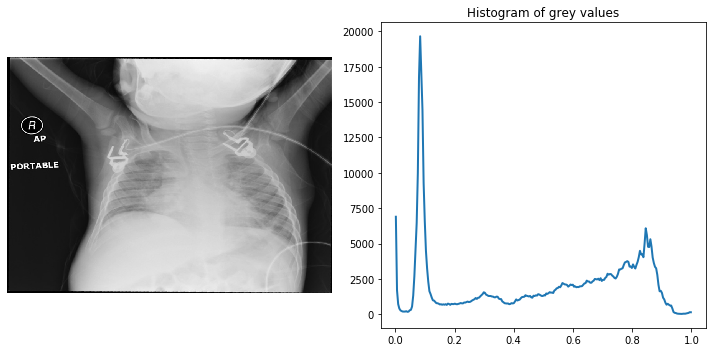

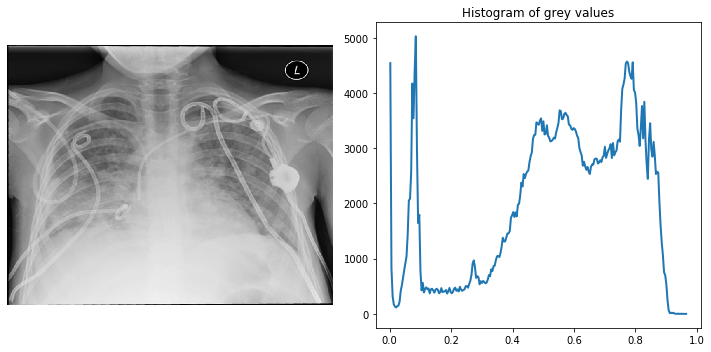

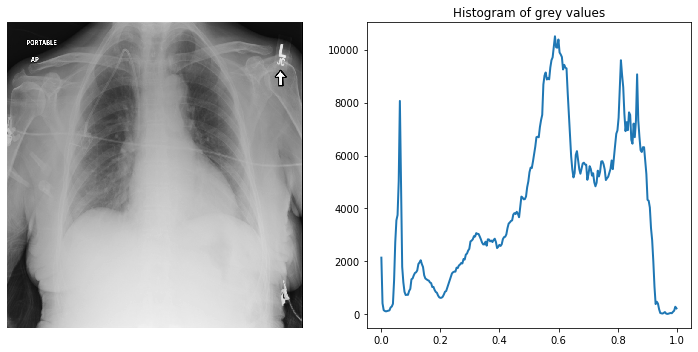

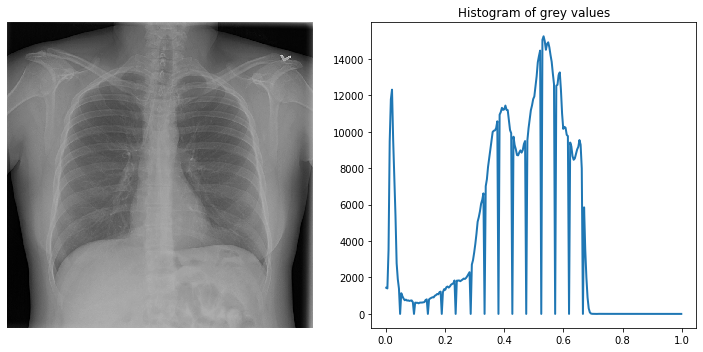

In [62]:



    hist, hist_centers = histogram(image)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[1].plot(hist_centers, hist, lw=2)
    ax[1].set_title('Histogram of grey values')
    plt.tight_layout()

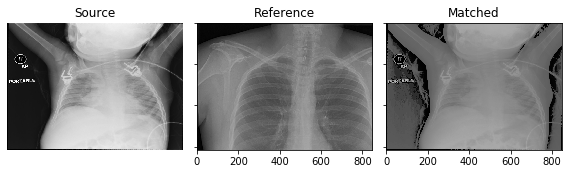

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

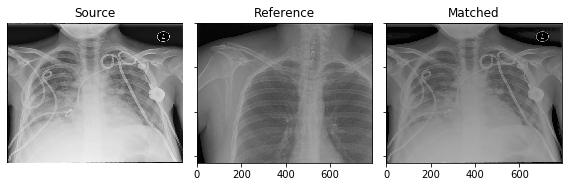

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

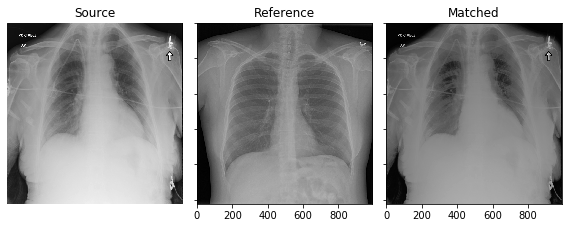

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [59]:
from skimage import exposure
from skimage.exposure import match_histograms

reference = wgood


for image in (wreal_bad, wbad, wmedium):
    matched = match_histograms(image, reference, multichannel=False)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()
        ax1.imshow(image, cmap ="gray")
        ax1.set_title('Source')
        ax2.imshow(reference, cmap ="gray")
        ax2.set_title('Reference')
        ax3.imshow(matched, cmap ="gray")
        ax3.set_title('Matched')
        plt.tight_layout()
        plt.show()



Felzenszwalb's number of segments: 60
Slic number of segments: 3
Quickshift number of segments: 220


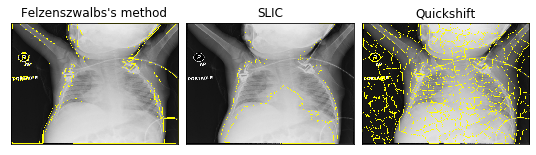

Felzenszwalb's number of segments: 67
Slic number of segments: 3
Quickshift number of segments: 229


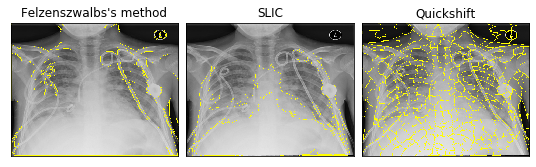

Felzenszwalb's number of segments: 78
Slic number of segments: 2
Quickshift number of segments: 484


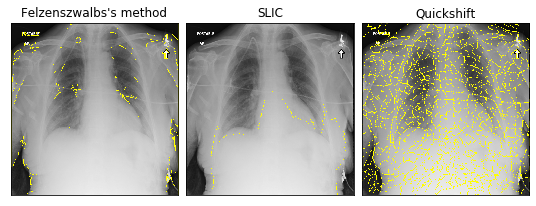

Felzenszwalb's number of segments: 93
Slic number of segments: 2
Quickshift number of segments: 481


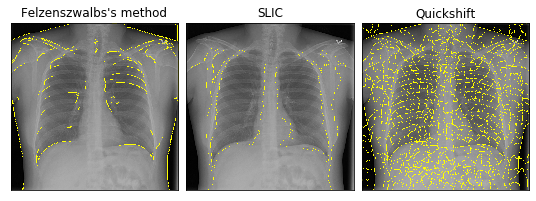

In [57]:


from __future__ import print_function




import matplotlib.pyplot as plt

import numpy as np
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

for image in (wreal_bad, wbad, wmedium, wgood):
    img = img_as_float(image)
    img = np.stack((img,img, img), axis=2)
    img.shape
    segments_fz = felzenszwalb(img, scale=1000, sigma=1, min_size=50)
    segments_slic = slic(img, n_segments=5, compactness=1, sigma=2)
    segments_quick = quickshift(img, kernel_size=5, max_dist=100, ratio=1)

    print("Felzenszwalb's number of segments: %d" % len(np.unique(segments_fz)))
    print("Slic number of segments: %d" % len(np.unique(segments_slic)))
 #   Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi, Pascal Fua, and Sabine Suesstrunk, 
#SLIC Superpixels Compared to State-of-the-art Superpixel Methods, TPAMI, May 2012.
    print("Quickshift number of segments: %d" % len(np.unique(segments_quick)))

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(8, 3, forward=True)
    fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)

    ax[0].imshow(mark_boundaries(img, segments_fz))
    ax[0].set_title("Felzenszwalbs's method")
    ax[1].imshow(mark_boundaries(img, segments_slic))
    ax[1].set_title("SLIC")
    ax[2].imshow(mark_boundaries(img, segments_quick))
    ax[2].set_title("Quickshift")
    for a in ax:
        a.set_xticks(())
        a.set_yticks(())
    plt.show()